<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP6_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D - any order

Finite Element Method solver of any order $k$ for the 1D Poisson problem:

$-u''=f \quad \text{in } \Omega=(a,b)$

$u|_{\partial\Omega}=0$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import sympy as sym

In [3]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)
  return (q + 1) / 2, w / 2

In [4]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the reference Basis functions

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q) - 1
    assert i >= 0
    return lambda x: q[i] + x * (q[i+1] - q[i])

def mapping_J(q, i):
    assert i < len(q) - 1
    assert i >= 0
    return (q[i+1] - q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: np.prod([(x - q[j]) / (q[i] - q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: np.full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q, i, order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q, i)(t).diff(t, order))

In [5]:
def mesh(omega,N):
  return np.linspace(omega[0], omega[1], N + 1)

FEM code any order

In [6]:
def FEM(omega,M,degree,n_qpoints,rhs):
  # 1D FEM with k=degree system matrix and rhs for
  # diffusion problem

  # Dimension of the problem
  N = M * degree +1

  vertices = mesh(omega, M) # grid

  # reference element (quadrature and Lagrange points)
  q, w = quadrature(n_qpoints)

  # lagrange_points are generated dynamically based on the polynomial degree.
  lagrange_points = np.linspace(0, 1, degree + 1)

  # evaluation of Lagrange basis at the quadrature points
  phi = np.array([lagrange_basis(lagrange_points, i)(q) for i in range(degree + 1)]).T
  dphi = np.array([lagrange_basis_derivative(lagrange_points, i)(q) for i in range(degree + 1)]).T

  # initialise system
  A = sp.lil_matrix((N, N))
  F = np.zeros(N)

  for i in range(M):
    JxW = mapping_J(vertices, i) * w
    ele_A = np.einsum('qi,qj,q', dphi, dphi, JxW) / mapping_J(vertices, i)**2
    ele_F = np.einsum('qi,q,q', phi, rhs(mapping(vertices, i)(q)), JxW)

    j = i * degree
    m = j + degree + 1
    A[j:m, j:m] += ele_A
    F[j:m] += ele_F

  return A, F

Apply boundary conditions

In [7]:
def apply_boundary_conditions(omega,A, F, g):
  # Ideally should scale entries as those of A
  N = A.shape[0] - 1
  A[0,A[0].nonzero()] = 0; A[0,0] = 1; F[0]=g(omega[0])
  A[N,A[N].nonzero()] = 0; A[N,N] = 1; F[N]=g(omega[1])

and solve

In [8]:
# Problem
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

degree = 3 # degree of FEM basis
n_qpoints = 2 * degree - 1 # Number of quadrature points
no_experiments = 7 # Number of experiments

MM = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)

for i in range(no_experiments):
  M = 2**(i + 2)
  MM[i] = M
  N = M * degree + 1

  A, F = FEM(omega, M, degree, n_qpoints, rhs) # call function computing FEM system
  apply_boundary_conditions(omega,A, F, sol)
  A_csr = A.tocsr()

  Uh = sp.linalg.spsolve(A_csr, F) # Solve the system

  # Compute exact solution
  x = np.linspace(omega[0], omega[1], N)
  U = sol(x)

  discrete_max_err[i] = max(abs(U - Uh)) # Compute discrete max norm error

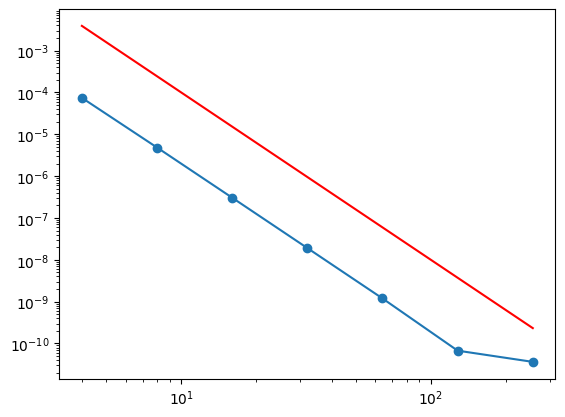

In [12]:
# Error loglog plots
plt.loglog(MM,discrete_max_err,'o-')
#plt.loglog(MM,interpola_H1_err**(1/2),'bd-')
plt.loglog(MM,MM**(-(degree+1)),'r')

In [13]:
print(MM)

[  4.   8.  16.  32.  64. 128. 256.]


**Exercise 1**: Write function computing $H^1$-norm error and test convergence for $k>1$.

In [14]:
# Define all necessary functions and placeholders
def H1_norm(omega, M, degree, u, u_h, n_qpoints):
    vertices = mesh(omega, M)
    q, w = quadrature(n_qpoints)
    lagrange_points = np.linspace(0, 1, degree + 1)

    phi = np.array([lagrange_basis(lagrange_points, i)(q) for i in range(degree + 1)]).T
    dphi = np.array([lagrange_basis_derivative(lagrange_points, i)(q) for i in range(degree + 1)]).T

    H1_norm_squared = 0.0

    for i in range(M):
        JxW = mapping_J(vertices, i) * w
        x = mapping(vertices, i)(q)

        # Error in function value
        e = u(x) - sum(u_h[i * degree + j] * phi[:, j] for j in range(degree + 1))
        H1_norm_squared += np.sum(e**2 * JxW)

        # Error in derivative value
        de = np.gradient(u(x), x) - sum(u_h[i * degree + j] * dphi[:, j] / mapping_J(vertices, i) for j in range(degree + 1))
        H1_norm_squared += np.sum(de**2 * JxW)

    return np.sqrt(H1_norm_squared)

def L2_norm(omega, M, degree, u, u_h, n_qpoints):
    vertices = mesh(omega, M)
    q, w = quadrature(n_qpoints)
    lagrange_points = np.linspace(0, 1, degree + 1)

    phi = np.array([lagrange_basis(lagrange_points, i)(q) for i in range(degree + 1)]).T

    L2_norm_squared = 0.0

    for i in range(M):
        JxW = mapping_J(vertices, i) * w
        x = mapping(vertices, i)(q)

        # Error in function value
        e = u(x) - sum(u_h[i * degree + j] * phi[:, j] for j in range(degree + 1))
        L2_norm_squared += np.sum(e**2 * JxW)

    return np.sqrt(L2_norm_squared)

def convergence(no_experiments, mesh, omega, degree, n_qpoints, exact, rhs):
    Err = np.zeros(no_experiments)
    L2_Err = np.zeros(no_experiments)
    H1_Err = np.zeros(no_experiments)
    MM = np.zeros(no_experiments)
    Cond = np.zeros(no_experiments)

    for i in range(no_experiments):
        M = 2**(i + 2)
        MM[i] = M
        N = M * degree + 1

        A, F = FEM(omega, M, degree, n_qpoints, rhs)
        apply_boundary_conditions(omega, A, F, exact)
        A_csr = A.tocsr()

        Uh = sp.linalg.spsolve(A_csr, F)
        Cond[i] = np.linalg.cond(A_csr.todense(), p=2)

        vertices = mesh(omega, M)
        U = exact(vertices)

        Err[i] = max(abs(U - Uh))
        L2_Err[i] = L2_norm(omega, M, degree, exact, Uh, n_qpoints)
        H1_Err[i] = H1_norm(omega, M, degree, exact, Uh, n_qpoints)

    return MM, Err, L2_Err, H1_Err, Cond

In [15]:
def convergence(no_experiments, mesh, omega, degree, n_qpoints, exact, rhs):
    Err = np.zeros(no_experiments)
    H1_Err = np.zeros(no_experiments)
    MM = np.zeros(no_experiments)
    Cond = np.zeros(no_experiments)

    for i in range(no_experiments):
        M = 2**(i + 2)
        MM[i] = M
        N = M * degree + 1

        A, F = FEM(omega, M, degree, n_qpoints, rhs)
        apply_boundary_conditions(omega, A, F, exact)
        A_csr = A.tocsr()

        Uh = sp.linalg.spsolve(A_csr, F)
        Cond[i] = np.linalg.cond(A_csr.todense(), p=2)

        vertices = mesh(omega, N - 1)
        U = exact(vertices)

        Err[i] = max(abs(U - Uh))
        H1_Err[i] = H1_norm(omega, M, degree, exact, Uh, n_qpoints)

    return MM, Err, H1_Err, Cond

In [16]:
def compute_slopes(NN, Err, H1_Err, Cond):
    slope_Err, _ = np.polyfit(np.log(NN), np.log(Err), 1)
    slope_H1, _ = np.polyfit(np.log(NN), np.log(H1_Err), 1)
    slope_Cond, _ = np.polyfit(np.log(NN), np.log(Cond), 1)

    return slope_Err, slope_H1, slope_Cond

In [17]:
omega = [0, np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

degree = 2
n_qpoints = 2 * degree - 1
no_experiments = 7

MM, Err, H1_Err, Cond = convergence(no_experiments, mesh, omega, degree, n_qpoints, exact, rhs)

print("MM:", MM)
print("Discrete Max Error:", Err)
print("H1 Norm Error:", H1_Err)
print("Condition Numbers:", Cond)

MM: [  4.   8.  16.  32.  64. 128. 256.]
Discrete Max Error: [1.79854031e-04 1.20946309e-05 7.69561408e-07 4.83119880e-08
 3.02269731e-09 1.89568805e-10 1.08963949e-11]
H1 Norm Error: [0.1394348  0.07070343 0.03547753 0.01775457 0.00887926 0.00443988
 0.00221997]
Condition Numbers: [4.14415157e+01 1.53912083e+02 5.86261396e+02 2.28091715e+03
 8.99028403e+03 3.56893683e+04 1.42209008e+05]


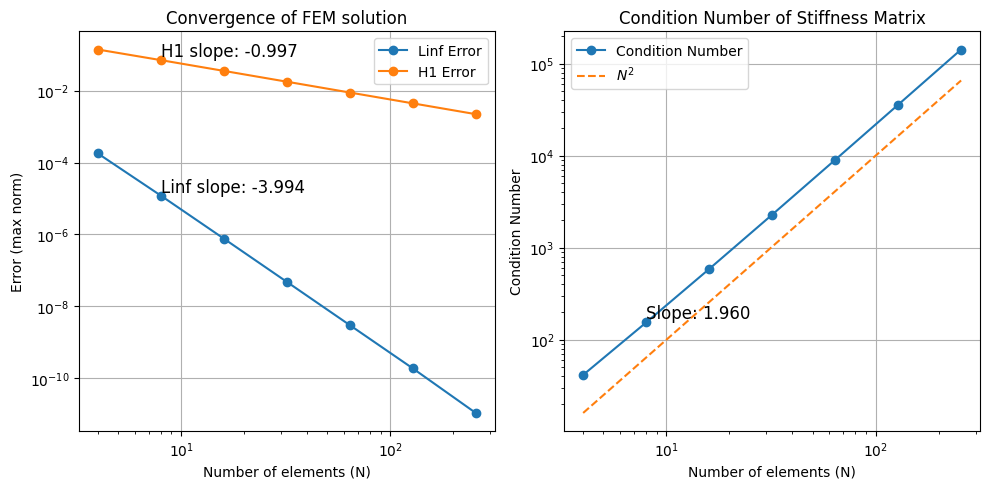

In [18]:
# experiment

NN, Err, H1_Err, Cond = convergence(no_experiments, mesh, omega, degree, n_qpoints, exact, rhs)
slope_Err, slope_H1, slope_Cond = compute_slopes(NN, Err, H1_Err, Cond)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.loglog(NN, Err, '-o', label='Linf Error')
ax1.loglog(NN, H1_Err, '-o', label='H1 Error')
ax1.text(NN[1], Err[1], f'Linf slope: {slope_Err:.3f}', fontsize=12, verticalalignment='bottom')
ax1.text(NN[1], H1_Err[1], f'H1 slope: {slope_H1:.3f}', fontsize=12, verticalalignment='bottom')
ax1.set_xlabel('Number of elements (N)')
ax1.set_ylabel('Error (max norm)')
ax1.set_title('Convergence of FEM solution')
ax1.legend()
ax1.grid(True)

ax2.loglog(NN, Cond, '-o', label='Condition Number')
ax2.loglog(NN, NN**2, '--', label='$N^2$')
ax2.text(NN[1], Cond[1], f'Slope: {slope_Cond:.3f}', fontsize=12, verticalalignment='bottom')
ax2.set_xlabel('Number of elements (N)')
ax2.set_ylabel('Condition Number')
ax2.set_title('Condition Number of Stiffness Matrix')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()